In [ ]:
%load_ext autoreload
%autoreload

In [ ]:
#!pip install openai
!pip install openai==0.28

In [ ]:
!pip install xlwt

In [ ]:
import openai
import pandas as pd
import numpy as np
import json
import os
import time

openai.api_key = "your_key"
COMPLETIONS_MODEL = "gpt-4"

In [ ]:
df = pd.read_csv('./test_data.csv')
size = len(df)
print(size)

331


In [ ]:
df.head(10)

,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0
5,CVE-2014-7235,htdocs_ari/includes/login.php in the ARI Frame...,0,0,1,0,0,0,1,0,0,0,0,0,0,0
6,CVE-2018-17877,A lottery smart contract implementation for Gr...,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,CVE-2020-4068,"In APNSwift 1.0.0, calling APNSwiftSigner.sign...",0,0,1,1,1,0,0,0,0,0,0,0,0,1
8,CVE-2021-24175,The Plus Addons for Elementor Page Builder Wor...,0,0,0,0,0,0,1,1,0,0,0,0,0,0
9,CVE-2021-31154,pleaseedit in please before 0.4 uses predictab...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered

In [ ]:
df.head(5)

,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
def request_completion(prompt):
    message=[{"role": "system", "content": prompt}]
    time.sleep(1)
    completion_response = openai.ChatCompletion.create(
      model=COMPLETIONS_MODEL,
      messages = message,
      temperature=0.2,
      max_tokens=1000,
      frequency_penalty=0.0
    )

    return completion_response

In [ ]:
zero_shot_prompt_long = '''You are a cybersecurity researcher. You receive the description of a vulnerability (CVE) and you map it to one of the 14 MITRE tactics.
The tactics and their descriptions are:
Reconnaissance - gather information they can use to plan future operations
Resource Development - establish resources they can use to support operations
Initial Access - get into your network
Execution - run malicious code
Persistence - maintain their foothold
Privilege Escalation - gain higher-level permissions
Defense Evasion - avoid being detected
Credential Access - steal account names and passwords
Discovery - figure out your environment
Lateral Movement - move through your environment
Collection - gather data of interest to their goal
Exfiltration - steal data
Command and Control - communicate with compromised systems to control them
Impact - manipulate, interrupt, or destroy your systems and data

The prediction must have the following format [predicted_tactic, predicted_tactic, ..]

CVE_DESCRIPTION: TEXT

The classification:'''

In [ ]:
zero_shot_prompt_short = '''You are a cybersecurity researcher. You receive the description of a vulnerability (CVE) and you map it to one of the 14 MITRE tactics.
The tactics are:
Resource Development
Initial Access
Execution
Persistence
Privilege Escalation
Defense Evasion
Credential Access
Discovery
Lateral Movement
Collection
Exfiltration
Command and Control
Impact
Reconnaissance

The prediction must have the following format [predicted_tactic, predicted_tactic, ..]

CVE_DESCRIPTION: TEXT

The classification:'''

In [ ]:
def get_ohe(x):
    labels_li = [' '.join(x.split()) for x in df.columns.to_list()[2:]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx

    x = x.replace("[", "")
    x = x.replace("]", "")

    x = x.replace("'", "")
    x = x.replace('"', "")

    y = x.split(',')
    y = [label.lstrip() for label in y]

    ohe = []

    temp = [0] * 14
    for label in y:
      idx = labels_li_indices.get(label, -1)
      if idx != -1:
        temp[idx] = 1

    return temp

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report
)

from sklearn.metrics import (
    recall_score,
    precision_score
)

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  sorted_results.head()
  return sorted_results.iloc[:, :limit]


def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [ ]:
true_all = []
predicted_all = []

for i in range (0, len(df)):
  entry = df.iloc[i]

  prompt = zero_shot_prompt_short.replace('TEXT', entry['Text'])
  print(entry['Text'])

  try:
    completion_response = request_completion(prompt)
  except Exception as e:
    print(f"An error occurred: {e}")
    continue

  response = completion_response['choices'][0]['message']['content']
  print(response)

  encoding = get_ohe(response)
  print(encoding)

  true = entry[2:].tolist()
  print(true)

  predicted_all.append(encoding)
  true_all.append(true)

  print("------------")

preds = np.array(predicted_all)
trues = np.array(true_all)

TeamViewer before 14.7.48644 on Windows loads untrusted DLLs in certain situations.
[Execution, Privilege Escalation, Defense Evasion]
[0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------
Microsoft Silverlight 5 before 5.1.41212.0 mishandles negative offsets during decoding, which allows remote attackers to execute arbitrary code or cause a denial of service (object-header corruption) via a crafted web site, aka "Silverlight Runtime Remote Code Execution Vulnerability."
[Initial Access, Execution, Impact]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
------------
Use-after-free vulnerability in the BitmapData class in the ActionScript 3 (AS3) implementation in Adobe Flash Player 13.x through 13.0.0.302 on Windows and OS X, 14.x through 18.0.0.203 on Windows and OS X, 11.x through 11.2.202.481 on Linux, and 12.x through 18.0.0.204 on Linux Chrome installations allows remote attackers to execute arbitra

In [ ]:
df = pd.DataFrame(preds)
output_file = 'gpt4_zero_shot_short.xls'
df.to_excel(output_file, index=False)

<ipython-input-15-4187ac8a13c6>:3: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  df.to_excel(output_file, index=False)


In [ ]:
val_weighted_f1_score = f1_score(trues, preds, average='weighted')
print('Val weighted f1 score:', val_weighted_f1_score)

Val weighted f1 score: 0.4695613316553164


In [ ]:
val_micro_f1_score = f1_score(trues, preds, average='micro')
print('Val micro f1 score:', val_micro_f1_score)

Val micro f1 score: 0.48798252002913334


In [ ]:
val_macro_f1_score = f1_score(trues, preds, average='macro')
print('Val macro f1 score:', val_macro_f1_score)

Val macro f1 score: 0.28527514626530764


In [ ]:
print('Val accuracy:', accuracy_score(trues, preds))
print('Val precision:', precision_score(trues, preds, average='weighted'))
print('Val recall:', recall_score(trues, preds, average='weighted'))

Val accuracy: 0.08181818181818182
Val precision: 0.4715588706349894
Val recall: 0.536


In [ ]:
df = df_filtered

In [ ]:
print("F1 Score per class")
f1_metrics = compute_metrics(preds, trues, f1_score, df.columns[2:], 14)

F1 Score per class


In [ ]:
f1_metrics.head()

,Execution,Impact,Credential Access,Exfiltration,Initial Access,Privilege Escalation,Discovery,Collection,Defense Evasion,Reconnaissance,Resource Development,Persistence,Lateral Movement,Command and Control
0,0.705521,0.616352,0.571429,0.5,0.492754,0.474138,0.27027,0.196721,0.166667,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Accuracy Score per class")
acc_metrics = compute_metrics(preds, trues, accuracy_score, df.columns[2:], 14)

Accuracy Score per class


In [ ]:
print(acc_metrics.head())

   Reconnaissance  Resource Development  Initial Access  Execution  \
0        0.081818              0.081818        0.081818   0.081818   

   Persistence  Privilege Escalation  Defense Evasion  Credential Access  \
0     0.081818              0.081818         0.081818           0.081818   

   Discovery  Lateral Movement  Collection  Command and Control  Exfiltration  \
0   0.081818          0.081818    0.081818             0.081818      0.081818   

     Impact  
0  0.081818  


In [ ]:
print("Precision Score per class")
precision_metrics = compute_metrics(preds, trues, precision_score, df.columns[2:], 14)

Precision Score per class


In [ ]:
precision_metrics.head()

,Collection,Execution,Impact,Credential Access,Initial Access,Exfiltration,Privilege Escalation,Discovery,Defense Evasion,Reconnaissance,Resource Development,Persistence,Lateral Movement,Command and Control
0,0.75,0.631868,0.620253,0.538462,0.456376,0.4,0.341615,0.217391,0.12069,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Recall Score per class")
recall_metrics = compute_metrics(preds, trues, recall_score, df.columns[2:], 14)

Recall Score per class


In [ ]:
print(recall_metrics.head())

   Execution  Privilege Escalation  Exfiltration  Impact  Credential Access  \
0   0.798611              0.774648      0.666667  0.6125           0.608696   

   Initial Access  Discovery  Defense Evasion  Collection  Reconnaissance  \
0        0.535433   0.357143         0.269231    0.113208             0.0   

   Resource Development  Persistence  Lateral Movement  Command and Control  
0                   0.0          0.0               0.0                  0.0  


In [ ]:
prev_df = pd.read_csv('./test_data.csv')
size = len(prev_df)

In [ ]:
distribution = prev_df.drop(prev_df.columns[0:2], axis=1)

In [ ]:
distribution.head()

,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0


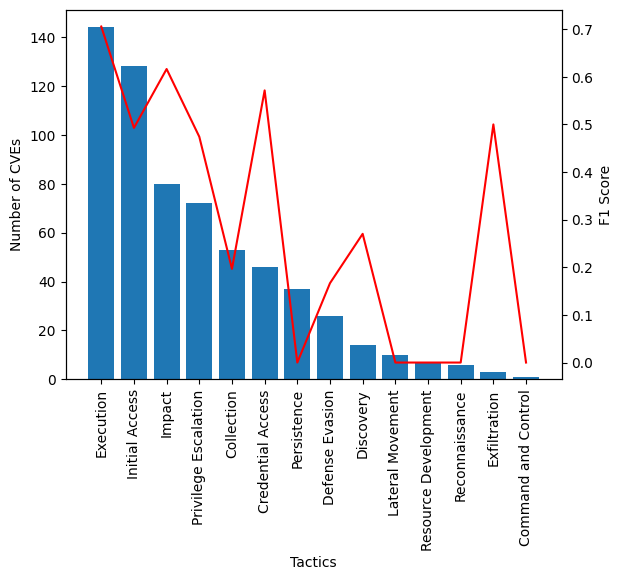

In [ ]:
print_F1_based_on_distribution(preds, trues, distribution,  df.columns[2:])